## Black-box attack exercise

In this exercise, you will implement the following black-box attack.
1. NES attack (NES)


In [1]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# 'cs231n' folder containing the '.py', 'classifiers' and 'datasets'
# folders.
# e.g. 'cs231n/assignments/assignment1/cs231n'
FOLDERNAME = "hw6_files"

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd /content/drive/My\ Drive/$FOLDERNAME/data
!bash download_data.sh
%cd ../models
!bash download_models.sh
%cd ..

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/hw6_files/data
------------------------------
Cifar-10 dataset already exits
------------------------------
/content/drive/My Drive/hw6_files/models
--------------------------------------
Naturally-trained model already exists
--------------------------------------
------------------------------------------
Adversarially-trained model already exists
------------------------------------------
/content/drive/My Drive/hw6_files


In [0]:
import math
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

from cifar10_input import CIFAR10Data
from model import Model

%load_ext autoreload
%autoreload 2

## Loading Cifar-10 test dataset

Loading Cifar-10 test dataset
The number of the test data: 10000


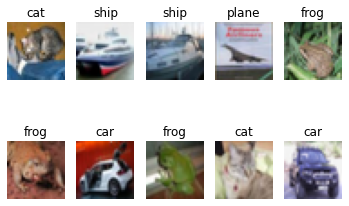

In [3]:
# Clear previously loaded data
try:
   del eval_data
   print('Clearing previously loaded data')
except:
   pass

# Load Cifar-10 test set
print('Loading Cifar-10 test dataset')
DATA_DIR = './data/cifar-10-batches-py'
eval_data = CIFAR10Data(DATA_DIR).eval_data

# Print the number of samples in the test set
print('The number of the test data: {}'.format(eval_data.n))

# Print the first 10 samples
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    sample_image = eval_data.xs[i]
    sample_label = eval_data.ys[i]
    plt.imshow(sample_image.astype('uint8'))
    plt.axis('off')
    plt.title(classes[sample_label])

## Restoring a naturally-trained ResNet classifier

In [4]:
# Reset all graphs
print('Clearing all graphs')
tf.reset_default_graph()

# Create a naturally-trained model
print('Creating a ResNet model')
model = Model(mode='eval')
sess = tf.Session()

# Restore parameters
print('Restoring parameters')
NAT_MODEL_DIR = './models/naturally_trained'
model_file = tf.train.latest_checkpoint(NAT_MODEL_DIR)

var_list = {}
with tf.variable_scope('', reuse=True):
  for var in tf.train.list_variables(model_file)[1:]:
    if 'Momentum' not in var[0]:
      var_list[var[0]] = tf.get_variable(name=var[0].replace('BatchNorm', 'batch_normalization'))

saver = tf.train.Saver(var_list=var_list)
saver.restore(sess, model_file)

Clearing all graphs
Creating a ResNet model
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Restoring parameters
INFO:tensorflow:Restoring parameters from ./models/naturally_trained/checkpoint-70000


## Evaluating the model

Before implementing attack methods, we have to evaluate the model for the following reasons.
1. To check whether the model is successfuly restored. 
2. To get samples that are correctly classified. We don't have to attack misclassified samples.

In [5]:
def evaluate(model, sess, data, indices, attack_method=None):
    """
    Given the data specified by the indices, evaluate the model.
    
    Args:
        model: TensorFlow model
        sess: TensorFlow session
        data: Cifar-10 test dataset
        indices: The indices that specify the data
        attack_method (optional): Instance of an attack method, If it is not None, the attack method is applied before
        evaluation.
    
    Return
        correct_prediction: NumPy array with the same shape as the indices. Given an index, 1 if the corresponding
        sample is correctly classifed, 0 otherwise.
    """
    
    correct_predictions = np.zeros([0], np.int32)
    
    num_images = len(indices)
    # batch_size set to 1 for NES attack
    batch_size = 1
    num_batches = int(math.ceil(num_images/batch_size))
    
    # Run batches
    for batch in range(num_batches):
        # Construct batch
        bstart = batch*batch_size
        bend = min(bstart+batch_size, num_images)
        image_batch = data.xs[indices[bstart:bend]]
        image_batch = np.int32(image_batch)
        label_batch = data.ys[indices[bstart:bend]]
        # Attack batch
        if attack_method is not None:
            image_batch = attack_method.perturb(image_batch, label_batch, sess)
        # Evaluate batch
        feed_dict = {
            model.x_input: image_batch, 
            model.y_input: label_batch
        }
        correct_prediction = sess.run(model.correct_prediction, feed_dict=feed_dict)
        correct_predictions = np.concatenate([correct_predictions, correct_prediction], axis=0)
    
    return correct_predictions

# Evaluate the naturally-trained model on the first 1000 samples in the test dataset
indices = np.arange(0, 1000)

print('Evaluating naturally-trained model')
correct_predictions = evaluate(model, sess, eval_data, indices)
accuracy = np.mean(correct_predictions)*100
print('Accuracy: {:.1f}%'.format(accuracy))

# Select the first 100 samples that are correctly classified.
correct_indices = np.where(correct_predictions==1)[0][:100]

Evaluating naturally-trained model
Accuracy: 96.2%


## Black-box attack with NES gradient estimation (NES)

Now, we will implement NES attack, a black-box attack method proposed by [Ilyas et al.](https://arxiv.org/abs/1804.08598), which uses vector-wise gradient estimation technique called NES and then performs PGD with those estimated gradients.

NES estimates the gradient by
<center>$\nabla_x L(\theta, x, y) \approx \frac{1}{\sigma n} \sum_{i}^{n}(L(x+\sigma u_i)-L(x-\sigma u_i))u_i$</center>

where each $u_i$ are image size random vectors sampled from standard normal distribution.


Your code for this section will all be written inside `attacks/nes_attack`.

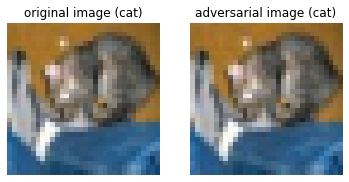

In [6]:
# First implement NES attack.
# Open attacks/nes_attack.py and follow instructions in the file.
from attacks.nes_attack import NESAttack

epsilon = 8
step_size = 2
num_steps = 20
loss_func = 'xent'

nes_attack = NESAttack(model, epsilon, step_size, num_steps, loss_func)

sample_image = eval_data.xs[correct_indices[0]]
sample_image = np.int32(sample_image)
sample_image = np.expand_dims(sample_image, axis=0)
sample_label = eval_data.ys[correct_indices[0]]
sample_label = np.expand_dims(sample_label, axis=0)
sample_adv_image = nes_attack.perturb(sample_image, sample_label, sess)
feed_dict = {
    model.x_input: sample_adv_image
}
sample_adv_label = sess.run(model.predictions, feed_dict=feed_dict)

# Check if the adversarial image is valid
assert np.amax(np.abs(sample_image-sample_adv_image)) <= epsilon
assert np.amin(sample_adv_image) >= 0
assert np.amax(sample_adv_image) <= 255

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(sample_image[0, ...].astype('uint8'))
plt.axis('off')
plt.title('original image ({})'.format(classes[sample_label[0]]))

# Plot the adversarial image
plt.subplot(1, 2, 2)
plt.imshow(sample_adv_image[0, ...].astype('uint8'))
plt.axis('off')
plt.title('adversarial image ({})'.format(classes[sample_adv_label[0]]));

# Evaluate performance on a naturally-trained model

Let's measure your attack's performance to check if you implemented it right. Also watch the attack success rate change as epsilon gets larger. If correctly implemented, the success rate will be about 75% or higher on epsilon 8. (Keep in mind that NES attack in our implementation attacks one image at a time, so the evaluation will take much longer than FGSM or PGD. Evaluation on a single epsilon may take up to 10 min.)

In [0]:
epsilons = [2, 4, 6, 8, 10]
attack_success_rates = []

for epsilon in epsilons:
    nes_attack = NESAttack(model, epsilon, step_size, num_steps, loss_func)
    correct_predictions = evaluate(model, sess, eval_data, correct_indices, attack_method=nes_attack)
    attack_success_rate = np.mean(1-correct_predictions)*100
    attack_success_rates.append(attack_success_rate)
    print('Epsilon: {}, Attack success rate: {:.1f}%'.format(epsilon, attack_success_rate))

plt.plot(epsilons, attack_success_rates, '-bo', label='NES (xent loss)')
plt.ylim(-5, 105)
plt.xticks(epsilons)
plt.yticks(np.arange(0, 110, 10))
plt.xlabel('epsilon')
plt.ylabel('attack success rate')
plt.legend();

# Attacks on adversarially-trained model

In [0]:
# Reset all graphs
tf.reset_default_graph()

# Create naturally-trained model
model = Model(mode='eval')
sess = tf.InteractiveSession()

# Restore parameters
ADV_MODEL_DIR = './models/adv_trained'
model_file = tf.train.latest_checkpoint(ADV_MODEL_DIR)

var_list = {}
with tf.variable_scope('', reuse=True):
  for var in tf.train.list_variables(model_file)[1:]:
    if 'Momentum' not in var[0]:
      var_list[var[0]] = tf.get_variable(name=var[0].replace('BatchNorm', 'batch_normalization'))

saver = tf.train.Saver(var_list=var_list)
saver.restore(sess, model_file)

In [0]:
# Check whether the model is successfully restored.
indices = np.arange(0, 1000)
correct_predictions = evaluate(model, sess, eval_data, indices)
accuracy = np.mean(correct_predictions)*100
print('Accuracy: {:.1f}%'.format(accuracy))

# Select the indices of the first 100 images that are correctly classified.
correct_indices = np.where(correct_predictions==1)[0][:100]

# Evaluate performance on an adversarially-trained model

This time you will check the same attack's performance on an adversarially-trained model. Check for differences on the success rate.

In [0]:
epsilons = [2, 4, 6, 8, 10]
attack_success_rates = []

for epsilon in epsilons:
    nes_attack = NESAttack(model, epsilon, step_size, num_steps, loss_func)
    correct_predictions = evaluate(model, sess, eval_data, correct_indices, attack_method=nes_attack)
    attack_success_rate = np.mean(1-correct_predictions)*100
    attack_success_rates.append(attack_success_rate)
    print('Epsilon: {}, Attack success rate: {:.1f}%'.format(epsilon, attack_success_rate))

plt.plot(epsilons, attack_success_rates, '-bo', label='NES (xent loss)')
plt.ylim(-5, 105)
plt.xticks(epsilons)
plt.yticks(np.arange(0, 110, 10))
plt.xlabel('epsilon')
plt.ylabel('attack success rate')
plt.legend();